In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import NearMiss
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
df = pd.read_csv("heart.csv")

In [ ]:
df.head()
#df.shape
# df.describe()
# df.info()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# ***Numerical and Categorical Features***

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Catgeorical Variable Selection
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Numerical Variable Selection
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [ ]:
# Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")


Observations: 4238
Variables: 16
Cat_cols: 8
Num_cols: 8
Cat_but_car: 0


   male     Ration
0  2419  57.078811
1  1819  42.921189
##########################################


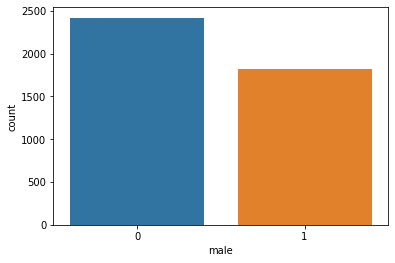

     education     Ration
1.0       1720  40.585182
2.0       1253  29.565833
3.0        687  16.210477
4.0        473  11.160925
##########################################


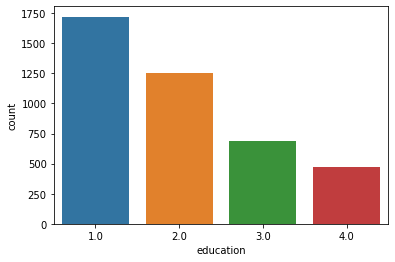

   currentSmoker     Ration
0           2144  50.589901
1           2094  49.410099
##########################################


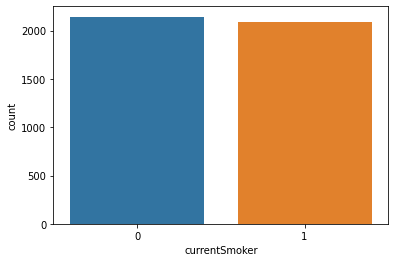

     BPMeds     Ration
0.0    4061  95.823502
1.0     124   2.925908
##########################################


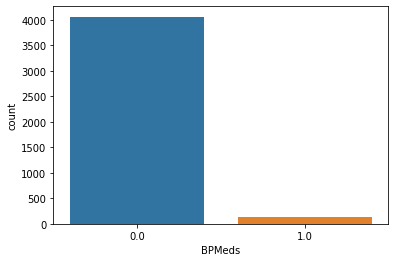

   prevalentStroke     Ration
0             4213  99.410099
1               25   0.589901
##########################################


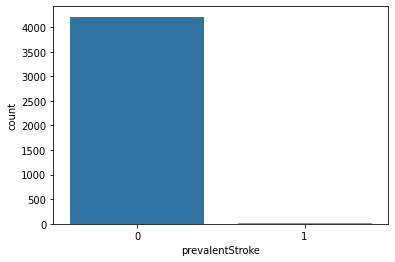

   prevalentHyp     Ration
0          2922  68.947617
1          1316  31.052383
##########################################


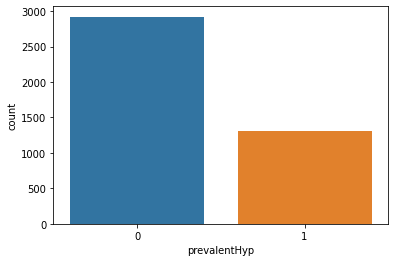

   diabetes     Ration
0      4129  97.428032
1       109   2.571968
##########################################


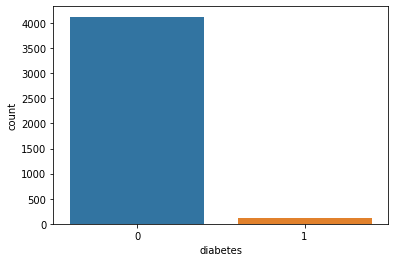

   TenYearCHD     Ration
0        3594  84.804153
1         644  15.195847
##########################################


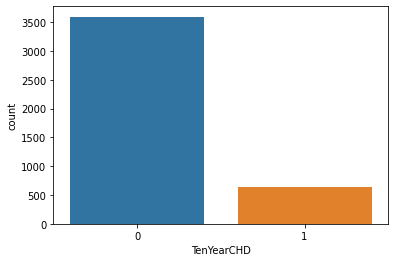

None


In [ ]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ration': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)


def cat_summary_df(dataframe):
    cat_cols, num_cols, cat_but_car = grab_col_names(df)
    for col in cat_cols:
        cat_summary(dataframe, col, plot=True)

print(cat_summary_df(df))

count    4238.000000
mean       49.584946
std         8.572160
min        32.000000
1%         35.000000
5%         37.000000
10%        39.000000
20%        41.000000
30%        44.000000
40%        46.000000
50%        49.000000
60%        52.000000
70%        55.000000
80%        58.000000
90%        62.000000
95%        64.000000
99%        67.000000
max        70.000000
Name: age, dtype: float64


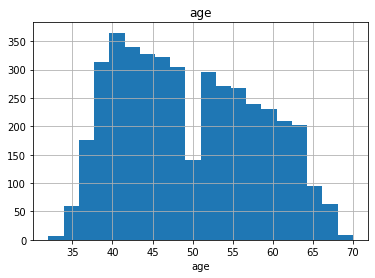

count    4209.000000
mean        9.003089
std        11.920094
min         0.000000
1%          0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         9.000000
70%        15.000000
80%        20.000000
90%        25.000000
95%        30.000000
99%        43.000000
max        70.000000
Name: cigsPerDay, dtype: float64


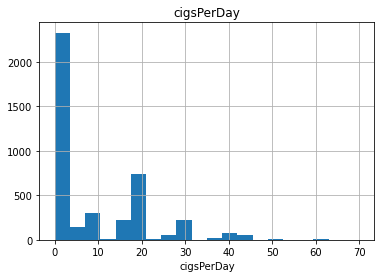

count    4188.000000
mean      236.721585
std        44.590334
min       107.000000
1%        153.000000
5%        170.000000
10%       183.000000
20%       200.000000
30%       212.000000
40%       223.000000
50%       234.000000
60%       244.000000
70%       257.000000
80%       271.000000
90%       292.000000
95%       312.000000
99%       354.130000
max       696.000000
Name: totChol, dtype: float64


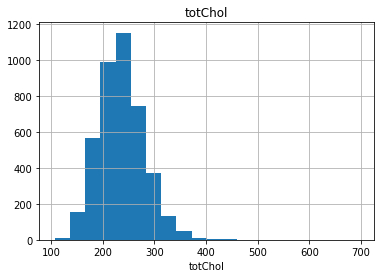

count    4238.000000
mean      132.352407
std        22.038097
min        83.500000
1%         97.000000
5%        104.000000
10%       108.850000
20%       114.000000
30%       119.500000
40%       124.000000
50%       128.000000
60%       133.000000
70%       140.000000
80%       148.000000
90%       162.000000
95%       175.000000
99%       200.000000
max       295.000000
Name: sysBP, dtype: float64


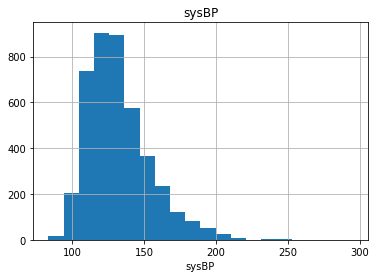

count    4238.000000
mean       82.893464
std        11.910850
min        48.000000
1%         60.000000
5%         66.000000
10%        69.000000
20%        73.000000
30%        76.000000
40%        80.000000
50%        82.000000
60%        85.000000
70%        87.500000
80%        92.000000
90%        98.000000
95%       104.575000
99%       118.000000
max       142.500000
Name: diaBP, dtype: float64


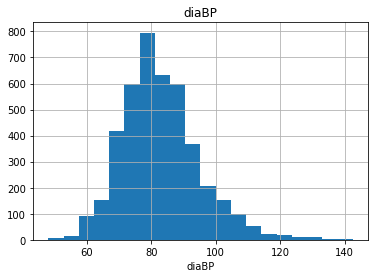

count    4219.000000
mean       25.802008
std         4.080111
min        15.540000
1%         18.163600
5%         20.060000
10%        21.088000
20%        22.530000
30%        23.564000
40%        24.470000
50%        25.400000
60%        26.350000
70%        27.420000
80%        28.690000
90%        30.770000
95%        32.782000
99%        38.956400
max        56.800000
Name: BMI, dtype: float64


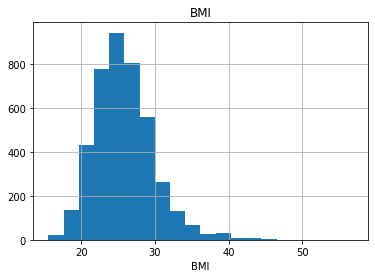

count    4237.000000
mean       75.878924
std        12.026596
min        44.000000
1%         52.000000
5%         60.000000
10%        60.000000
20%        65.000000
30%        70.000000
40%        72.000000
50%        75.000000
60%        77.000000
70%        80.000000
80%        85.000000
90%        92.000000
95%        98.000000
99%       110.000000
max       143.000000
Name: heartRate, dtype: float64


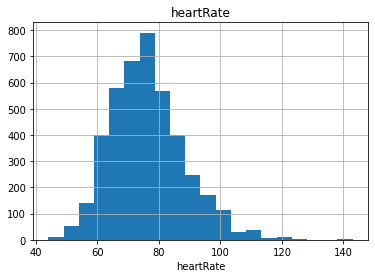

count    3850.000000
mean       81.966753
std        23.959998
min        40.000000
1%         55.000000
5%         62.000000
10%        65.000000
20%        70.000000
30%        73.000000
40%        75.000000
50%        78.000000
60%        81.000000
70%        85.000000
80%        89.000000
90%        98.000000
95%       108.550000
99%       175.040000
max       394.000000
Name: glucose, dtype: float64


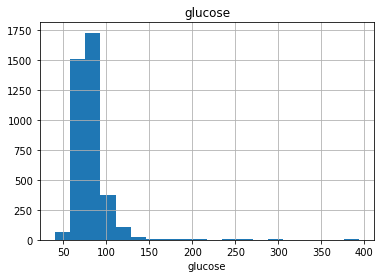

None


In [ ]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

print(num_summary_df(df))

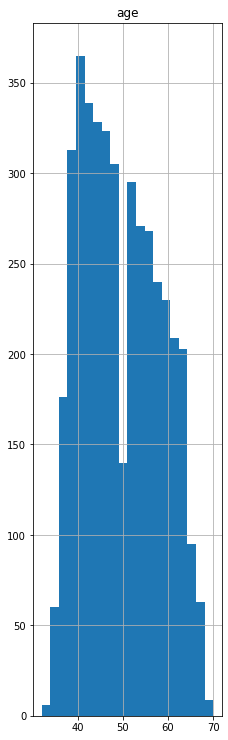

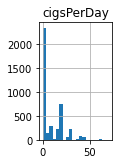

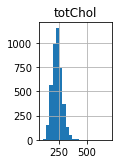

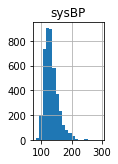

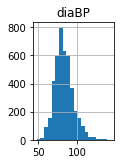

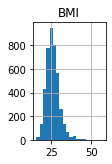

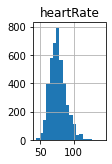

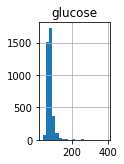

None


In [ ]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
  plt.figure(figsize=(12, 20))
  for index, col in enumerate(num_cols):
    plt.subplot(2, 4, index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)
    plt.show()

print(plot_num_summary(df))

In [ ]:
# def target_summary_with_num(dataframe, target, numerical_col):
#   print(dataframe.groupby(target).agg({numerical_col: "mean"}))
#   print("#############################################")

# def target_summary_with_num_df(dataframe, target):
#   cat_cols, num_cols, cat_but_car = grab_col_names(df)
#   for col in num_cols:
#     target_summary_with_num(dataframe, target, col)

# print(target_summary_with_num_df(df,'Outcome'))


# ***EDA- Histplot and Boxplot***

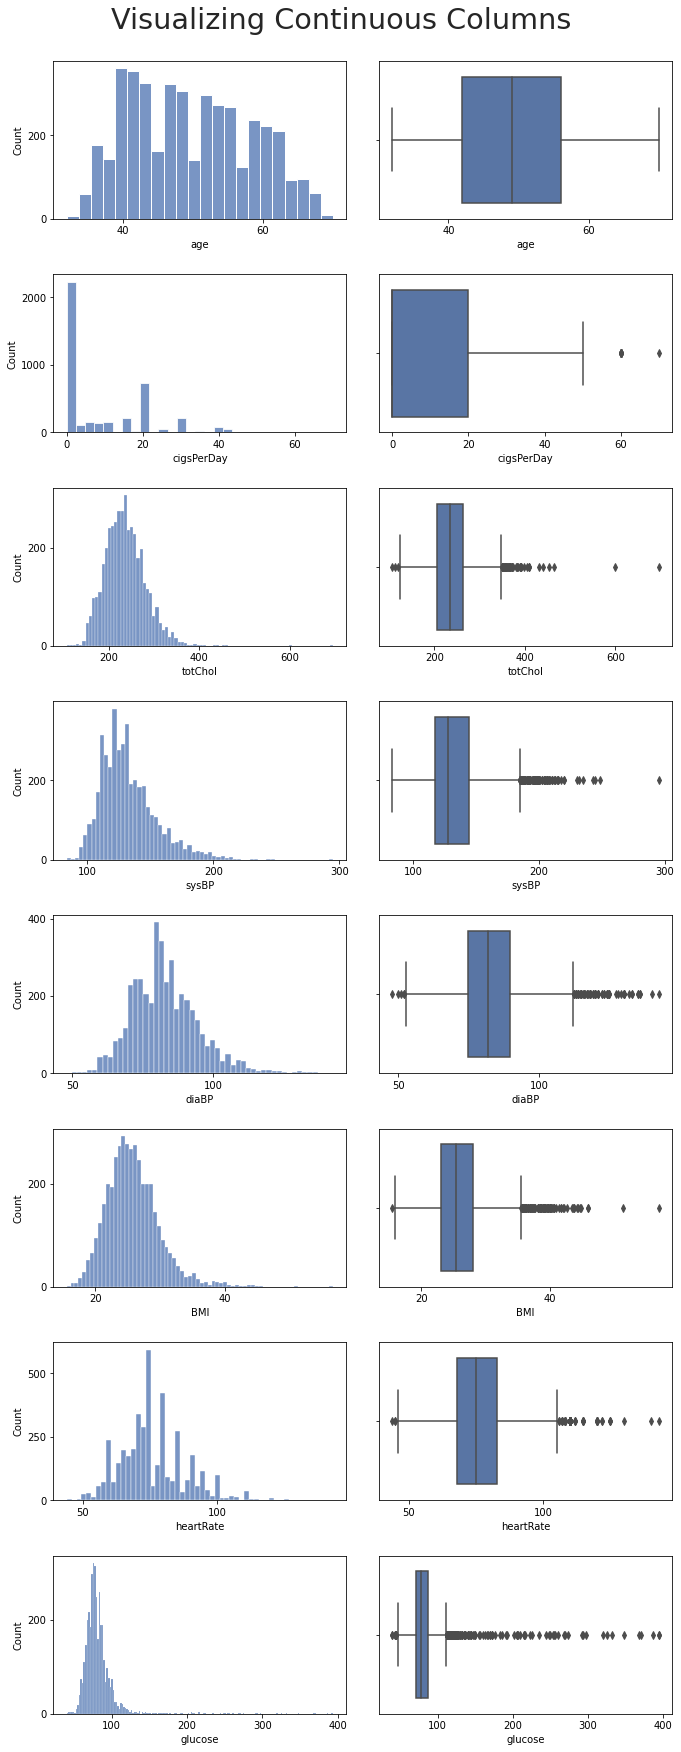

None


In [ ]:
import scipy.stats as stats
def exploratory_data(dataframe):
    import warnings
    warnings.filterwarnings('ignore')
    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
    fig, ax = plt.subplots(8, 2, figsize=(10, 25))
    sns.set(font_scale=2)
    for index, col in enumerate(num_cols):
        sns.histplot(dataframe[col], ax=ax[index, 0])
        sns.boxplot(dataframe[col], ax=ax[index, 1])
        # stats.probplot(dataframe[col], plot=ax[index, 2])
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.suptitle("Visualizing Continuous Columns")
    plt.show()

print(exploratory_data(df))

# ***Visualizing Missing Data***
We can use seaborn to create a simple heatmap to see where we are missing data!

In [ ]:
df.isnull()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4234,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4235,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4236,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


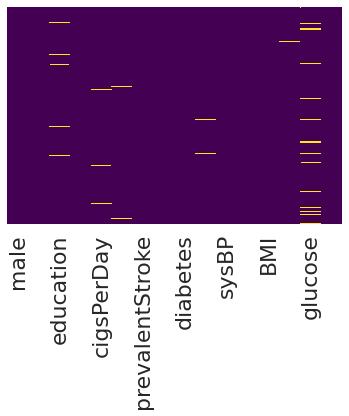

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# ***Cleaning***

In [ ]:
df.corr()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.000000,-0.028979,0.017352,0.197596,0.317930,-0.052506,-0.004546,0.005313,0.015708,-0.070322,-0.035989,0.057933,0.081672,-0.116620,0.006083,0.088428
age,-0.028979,1.000000,-0.165883,-0.213748,-0.192791,0.122995,0.057655,0.307194,0.101258,0.262131,0.394302,0.206104,0.135800,-0.012823,0.122256,0.225256
education,0.017352,-0.165883,1.000000,0.018532,0.008085,-0.010815,-0.035112,-0.081970,-0.038680,-0.023115,-0.129631,-0.062316,-0.137504,-0.054206,-0.035721,-0.054059
currentSmoker,0.197596,-0.213748,0.018532,1.000000,0.769690,-0.048938,-0.032988,-0.103260,-0.044295,-0.046562,-0.130230,-0.107746,-0.167650,0.062356,-0.056826,0.019456
cigsPerDay,0.317930,-0.192791,0.008085,0.769690,1.000000,-0.046134,-0.032707,-0.066146,-0.037067,-0.026320,-0.088780,-0.056632,-0.092856,0.075157,-0.058960,0.057884
BPMeds,-0.052506,0.122995,-0.010815,-0.048938,-0.046134,1.000000,0.117365,0.261187,0.052047,0.080558,0.254219,0.194227,0.100668,0.015233,0.051176,0.087489
prevalentStroke,-0.004546,0.057655,-0.035112,-0.032988,-0.032707,0.117365,1.000000,0.074830,0.006949,0.000067,0.057009,0.045190,0.025891,-0.017676,0.018431,0.061810
prevalentHyp,0.005313,0.307194,-0.081970,-0.103260,-0.066146,0.261187,0.074830,1.000000,0.077808,0.163993,0.696755,0.615751,0.301318,0.147261,0.086834,0.177603
diabetes,0.015708,0.101258,-0.038680,-0.044295,-0.037067,0.052047,0.006949,0.077808,1.000000,0.040278,0.111283,0.050329,0.087036,0.048994,0.617627,0.097317
totChol,-0.070322,0.262131,-0.023115,-0.046562,-0.026320,0.080558,0.000067,0.163993,0.040278,1.000000,0.208908,0.165182,0.115767,0.091125,0.046408,0.082184


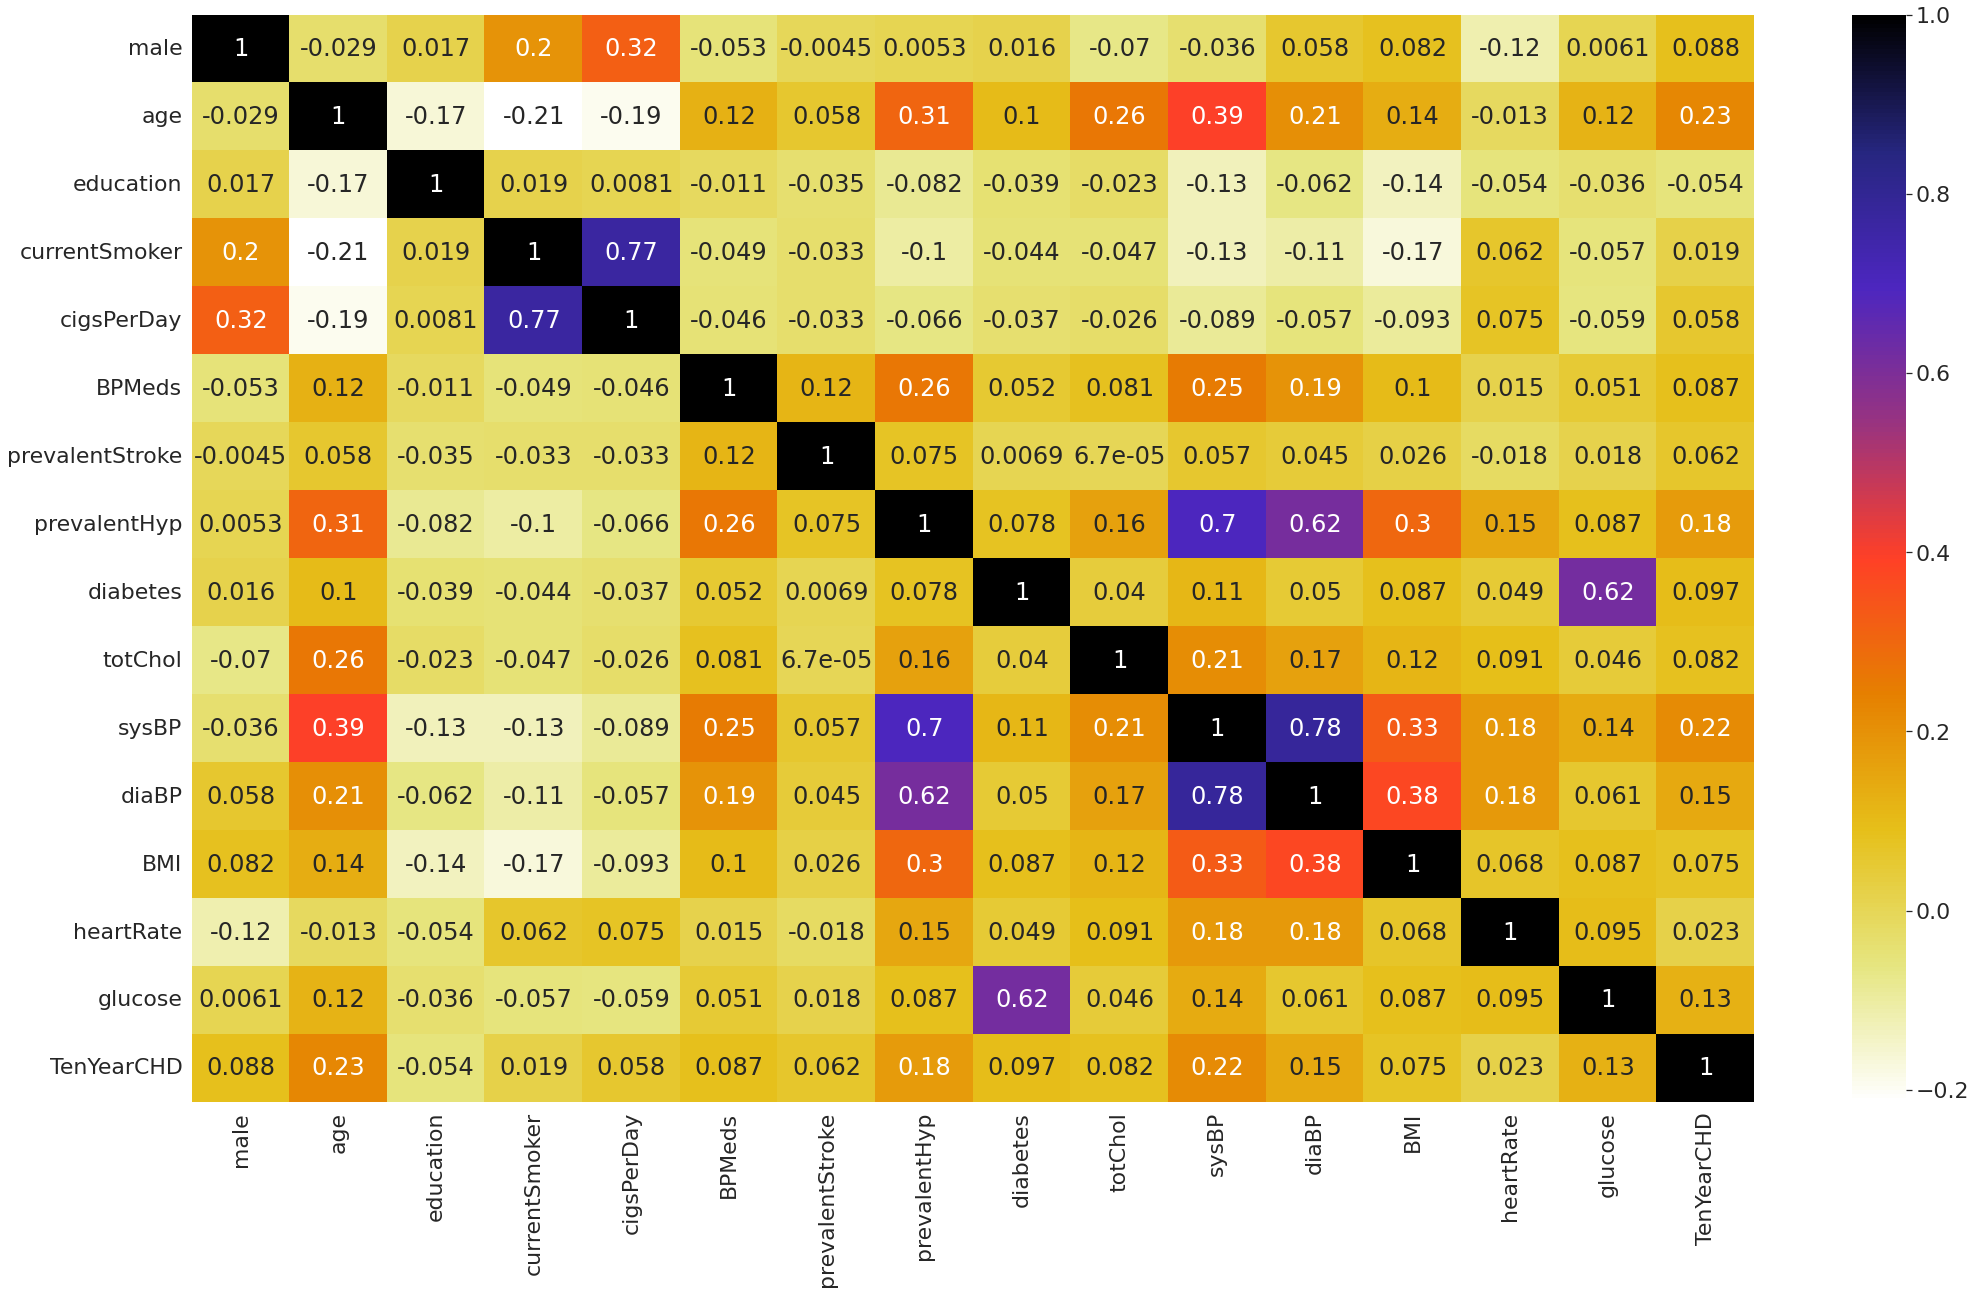

In [ ]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(35,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
# currentSmoker can also be removed. Should check one time. done
# To check class weight and to check first f score and recall to check majority and minority to check whether it is biased toward majority class done
# To check imbalanced using SMOTE or NearMiss done
# To handle outliers using either Z-score or quantile method to remove or capping the outliers. Box plot has been done already in EDA- histplot and boxplot step. done